# Simulations with WindGym Environments

This notebook provides a comprehensive guide to running simulations in WindGym, focusing on the core environment classes: `WindFarmEnv` and `FarmEval`. We'll explore their differences, intended use cases, and how to interact with them for both single-agent and multi-agent scenarios.

## 1. Core WindGym Environments: `WindFarmEnv` vs. `FarmEval`

WindGym offers two primary environment classes for different simulation needs:

1.  **`WindFarmEnv`**: The base, general-purpose environment.
2.  **`FarmEval`**: A specialized subclass of `WindFarmEnv` designed specifically for evaluation and fixed-condition simulations.

Understanding their relationship and distinctions is crucial for effective use of WindGym.

### `WindFarmEnv`: The Flexible Base Environment

`WindFarmEnv` is your go-to environment for general-purpose wind farm simulations. It's designed to be flexible, supporting various configurations and dynamic wind conditions, making it suitable for:

* **Reinforcement Learning Training**: Agents can learn to adapt to changing wind conditions over long episodes.
* **Stochastic Wind Sampling**: It can integrate with PyWake `Site` objects (`sample_site` parameter) to sample realistic wind speeds and directions based on wind resource distributions (e.g., Weibull for speed, frequency for direction). If `sample_site` is not provided, it samples uniformly from defined min/max ranges.
* **Dynamic Changes**: While this version primarily uses steady wind within an episode, `WindFarmEnv`'s architecture allows for future extensions that could introduce wind changes mid-episode.
* **Multi-Agent Foundation**: It serves as the base for the `WindFarmEnvMulti` environment (discussed later) for decentralized control problems.

### `FarmEval`: The Evaluation-Focused Environment

`FarmEval` is a direct subclass of `WindFarmEnv` (`class FarmEval(WindFarmEnv):`). It inherits all capabilities of `WindFarmEnv` but **overrides key behaviors** to facilitate precise and reproducible evaluations under specific, controlled conditions. Its main features include:

* **Fixed Wind Conditions**: `FarmEval` allows you to *directly set* the wind speed (`ws`), wind direction (`wd`), and turbulence intensity (`ti`) via `set_wind_vals()` *before* calling `reset()`. This overrides any stochastic sampling, ensuring the environment always starts with the exact specified wind conditions.
* **Evaluation Loop Compatibility**: It is specifically used by the `AgentEval` class (and its `eval_single_fast` function) for running standardized benchmarks, as demonstrated later in this notebook.
* **Non-Terminating Episodes**: By default, `FarmEval` episodes are "infinite" (or very long, set by `time_max = 9999999`) unless `finite_episode=True` is explicitly set. This ensures that evaluation runs for a consistent duration without premature termination.
* **Baseline Comparison**: It often enables the `Baseline_comp=True` flag by default or is configured to always run a parallel baseline simulation for direct comparison of agent performance.

### Key Differences Summary

| Feature                  | `WindFarmEnv`                                        | `FarmEval`                                                 |
| :----------------------- | :--------------------------------------------------- | :--------------------------------------------------------- |
| **Base Class** | `gymnasium.Env`                                      | `WindFarmEnv`                                              |
| **Primary Use** | RL Training, General Simulation (stochastic wind)    | Fixed-condition Evaluation, Benchmarking                   |
| **Wind Conditions** | Randomly sampled (from ranges or `sample_site`)      | Explicitly set via `set_wind_vals()` (overrides sampling) |
| **Episode Length** | Defined by `n_passthrough`, can terminate/truncate   | Effectively 'infinite' by default (`time_max` overwritten) |
| **`reset()` behavior** | Samples new wind unless overridden                   | Uses explicitly set wind conditions                        |
| **Stochasticity** | High (wind sampling, turbulence generation)          | Controlled (fixed wind for evaluation)                     |
| **Parameter Setting** | Parameters set during initialization (`__init__`)    | Parameters can be explicitly set/overridden via methods    |

---

Now, let's start by setting up the necessary imports and a `config.yaml` file that both environments will use.

### Initial Setup: Imports and Configuration File

We'll need common Python libraries and specific WindGym components. We'll also define a `config.yaml` file, which specifies various environment parameters like observation details, reward functions, and action methods. Ensure this `config.yaml` is saved in the same directory as this notebook.

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import os
import yaml
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Import WindGym environment classes
from WindGym.Wind_Farm_Env import WindFarmEnv
from WindGym.FarmEval import FarmEval
from WindGym.AgentEval import eval_single_fast
from WindGym.Agents import PyWakeAgent, RandomAgent
from WindGym.WindEnvMulti import WindFarmEnvMulti

# Import a default turbine model from PyWake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site # Hornsrev1Site for stochastic wind example

#### `config.yaml` Content

Create a file named `config.yaml` in the same directory as this notebook with the following content. This file defines the detailed behavior of the WindGym environments.

In [2]:
# This cell is for display purposes only. 
# You should create a physical file named 'config.yaml' with this content.
config_yaml_content = """
yaw_init: "Zeros"
noise: "None"
BaseController: "Local"
ActionMethod: "wind"
Track_power: False
act_pen:
  action_penalty: 0.0
  action_penalty_type: "Change"
power_def:
  Power_scaling: 1000000000.0
  Power_avg: 50
  Power_reward: "Baseline"
mes_level:
  turb_ws: True
  turb_wd: True
  turb_TI: False
  turb_power: True
  farm_ws: True
  farm_wd: True
  farm_TI: False
  farm_power: True
  ti_sample_count: 30
ws_mes:
  ws_current: False
  ws_rolling_mean: True
  ws_history_N: 1
  ws_history_length: 10
  ws_window_length: 10
wd_mes:
  wd_current: False
  wd_rolling_mean: True
  wd_history_N: 1
  wd_history_length: 10
  wd_window_length: 10
yaw_mes:
  yaw_current: False
  yaw_rolling_mean: True
  yaw_history_N: 2
  yaw_history_length: 30
  yaw_window_length: 1
power_mes:
  power_current: False
  power_rolling_mean: True
  power_history_N: 1
  power_history_length: 10
  power_window_length: 10
farm:
  yaw_min: -45
  yaw_max: 45
wind:
  ws_min: 8.0
  ws_max: 12.0
  TI_min: 0.07
  TI_max: 0.15
  wd_min: 260.0
  wd_max: 280.0
"""

# Write the content to config.yaml if it doesn't exist
yaml_path = 'config.yaml'
if not os.path.exists(yaml_path):
    with open(yaml_path, 'w') as f:
        f.write(config_yaml_content)
    print(f"Created '{yaml_path}' with default content.")
else:
    print(f"'{yaml_path}' already exists. Using existing file.")

'config.yaml' already exists. Using existing file.


## 2. Basic `WindFarmEnv` Usage: Training Environment

Let's demonstrate how to initialize and interact with the base `WindFarmEnv`. This environment is typically used for training Reinforcement Learning agents, where wind conditions might vary from episode to episode.

In [3]:
# Define turbine positions (e.g., two turbines placed along the x-axis)
x_pos_base = np.array([0, 500])  # Meters
y_pos_base = np.array([0, 0])    # Meters

# Initialize the WindFarmEnv
env = WindFarmEnv(
    turbine=V80(),              # The wind turbine model to use
    x_pos=x_pos_base,           # X-coordinates of the turbines
    y_pos=y_pos_base,           # Y-coordinates of the turbines
    n_passthrough=5,            # Simulate for 5 "flow passthroughs" to define episode length
    dt_sim=1,                   # Internal simulation timestep in seconds (e.g., DWM solver step)
    dt_env=5,                   # Environment timestep in seconds (how often the agent acts)
                                # dt_env must be a multiple of dt_sim
    yaw_step_sim=1,             # Maximum 1 degree yaw change per dt_sim
    yaml_path=yaml_path,        # Path to the YAML configuration file
    Baseline_comp=True,         # Enable a parallel baseline farm for comparison
    render_mode=None,           # Set to 'human' for visualization, 'None' for headless operation
    seed=42                     # Random seed for reproducibility
)

print(f"Initialized WindFarmEnv: Observation Space {env.observation_space}, Action Space {env.action_space}")

Initialized WindFarmEnv: Observation Space Box(-1.0, 1.0, (13,), float32), Action Space Box(-1.0, 1.0, (2,), float32)


### Interacting with `WindFarmEnv`: `reset()` and `step()`

The standard Gymnasium API (`reset()` and `step()`) is used for interaction.

#### Resetting the Environment

`env.reset()` initializes a new episode. In `WindFarmEnv`, this involves sampling new global wind conditions (speed, direction, turbulence intensity) within the ranges defined in `config.yaml`, setting up a turbulence field, initializing turbine yaw angles, and running a "burn-in" period to stabilize the flow.

In [4]:
# Reset the environment to start a new episode
observation, info = env.reset()

print("\n--- Initial State of WindFarmEnv ---")
print("Initial Observation (scaled between -1 and 1):\n", observation)
print("\nInitial Info Dictionary (contains raw values and metadata):")
for key, value in info.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
    else:
        print(f"  {key}: {value}")

print(f"\nInitial Wind Conditions for this episode: WS={info['Wind speed Global']:.2f} m/s, WD={info['Wind direction Global']:.2f} deg, TI={info['Turbulence intensity']:.2f}")


--- Initial State of WindFarmEnv ---
Initial Observation (scaled between -1 and 1):
 [-0.4283145   0.5502809   0.          0.         -0.13359714 -0.4853108
  0.53599346  0.          0.         -0.32335526 -0.45681268  0.5431373
 -0.22847617]

Initial Info Dictionary (contains raw values and metadata):
  yaw angles agent: shape=(2,), dtype=float64
  yaw angles measured: shape=(4,), dtype=float32
  Wind speed Global: 8.376709391550598
  Wind speed at turbines: shape=(2,), dtype=float64
  Wind speed at turbines measured: shape=(2,), dtype=float32
  Wind speed at farm measured: shape=(1,), dtype=float32
  Wind direction Global: 275.22279403980707
  Wind direction at turbines: shape=(2,), dtype=float64
  Wind direction at turbines measured: shape=(2,), dtype=float32
  Wind direction at farm measured: shape=(1,), dtype=float32
  Turbulence intensity: 0.14804978813094047
  Power agent: 2085915.779813882
  Power pr turbine agent: shape=(2,), dtype=float64
  Turbine x positions: shape=(2,), d

#### Taking Steps (`env.step()`)

In each `step()`, your agent provides an `action` (a NumPy array scaled between -1 and 1), and the environment returns the `next_observation`, `reward`, `terminated` flag, `truncated` flag, and an updated `info` dictionary.

In [5]:
num_steps = 5 # Number of environment steps to simulate

print(f"\nRunning {num_steps} steps in WindFarmEnv with random actions...")
for i in range(num_steps):
    # Check if the episode has ended
    if info.get('terminated', False) or info.get('truncated', False):
        print(f"Episode ended at step {i}.\n")
        break

    # Sample a random action from the environment's action space
    action = env.action_space.sample()

    # Take a step in the environment with the sampled action
    observation, reward, terminated, truncated, info = env.step(action)

    print(f"\n--- Step {i+1} ---")
    print(f"Action (raw): {action}")
    print(f"Reward: {reward:.4f}")
    print(f"Farm Power (Agent): {info['Power agent'] / 1e6:.2f} MW")
    if 'Power baseline' in info: # Baseline power is only available if Baseline_comp is True
        print(f"Farm Power (Baseline): {info['Power baseline'] / 1e6:.2f} MW")
    print(f"Current Yaw Angles (Agent): {np.round(info['yaw angles agent'], 2)}")
    print(f"Time: {info['time_array'][-1]:.2f} s")
    
print("\nClosing WindFarmEnv...")
env.close()
print("WindFarmEnv closed.")


Running 5 steps in WindFarmEnv with random actions...

--- Step 1 ---
Action (raw): [ 0.50321776 -0.42260578]
Reward: -45960.5606
Farm Power (Agent): 1.81 MW
Farm Power (Baseline): 1.82 MW
Current Yaw Angles (Agent): [ 5. -5.]
Time: 273.00 s

--- Step 2 ---
Action (raw): [-0.07143772 -0.61739415]
Reward: -202840.8866
Farm Power (Agent): 1.49 MW
Farm Power (Baseline): 1.51 MW
Current Yaw Angles (Agent): [  0. -10.]
Time: 278.00 s

--- Step 3 ---
Action (raw): [ 0.89304537 -0.22315593]
Reward: -461061.3177
Farm Power (Agent): 1.66 MW
Farm Power (Baseline): 1.69 MW
Current Yaw Angles (Agent): [  5.   -10.04]
Time: 283.00 s

--- Step 4 ---
Action (raw): [-0.9902663   0.84496224]
Reward: -567350.3775
Farm Power (Agent): 1.93 MW
Farm Power (Baseline): 1.93 MW
Current Yaw Angles (Agent): [ 0.   -5.04]
Time: 288.00 s

--- Step 5 ---
Action (raw): [0.81709915 0.5635286 ]
Reward: -586678.0244
Farm Power (Agent): 1.99 MW
Farm Power (Baseline): 2.00 MW
Current Yaw Angles (Agent): [ 5.   -0.04]
Ti

## 3. Running Simulations with `FarmEval`: Evaluation and Pre-built Agents

`FarmEval` is ideal for reproducible evaluations under fixed wind conditions, which is crucial for benchmarking and comparing different agents. Here, we'll use it to evaluate a `PyWakeAgent`.

In [6]:
# Define turbine positions for a small farm for evaluation (e.g., three turbines in a row)
x_pos_eval = np.array([0, 600, 1200]) # meters
y_pos_eval = np.array([0, 0, 0])      # meters

# Initialize the FarmEval environment
eval_env = FarmEval(
    turbine=V80(),
    x_pos=x_pos_eval,
    y_pos=y_pos_eval,
    dt_sim=1,
    dt_env=10,
    yaw_step_sim=1,
    yaml_path=yaml_path,
    Baseline_comp=True,     # Essential for comparing agent to a baseline
    render_mode=None,       # Typically headless for evaluations to speed up
    seed=42,
    # For fixed wind condition evaluation, ensure sample_site is None.
    # The wind conditions are set directly via eval_env.set_wind_vals().
    sample_site=None,
)

# Set specific, fixed wind conditions for this evaluation run BEFORE resetting
eval_env.set_wind_vals(ws=10.0, ti=0.07, wd=270.0)

# Initialize the PyWakeAgent
# The PyWakeAgent calculates optimal yaw angles based on the current wind conditions
pywake_agent = PyWakeAgent(
    x_pos=x_pos_eval,
    y_pos=y_pos_eval,
    turbine=V80(),
    env=eval_env # Pass the environment object to the agent for context
)

print("\n--- Running simulation with PyWakeAgent using eval_single_fast ---")
# eval_single_fast runs a full episode with the specified agent and returns an xarray Dataset
# t_sim specifies the total simulation time in seconds
eval_results = eval_single_fast(
    env=eval_env,
    model=pywake_agent,
    ws=10.0,
    ti=0.07,
    wd=270.0,
    t_sim=6,     
    save_figs=False,        # Set to True to generate frame-by-frame plots (can be very slow)
    debug=False,
    deterministic=True,     # Use deterministic policy for the agent
    name="PyWake_3Turbines_Test"
)




--- Running simulation with PyWakeAgent using eval_single_fast ---


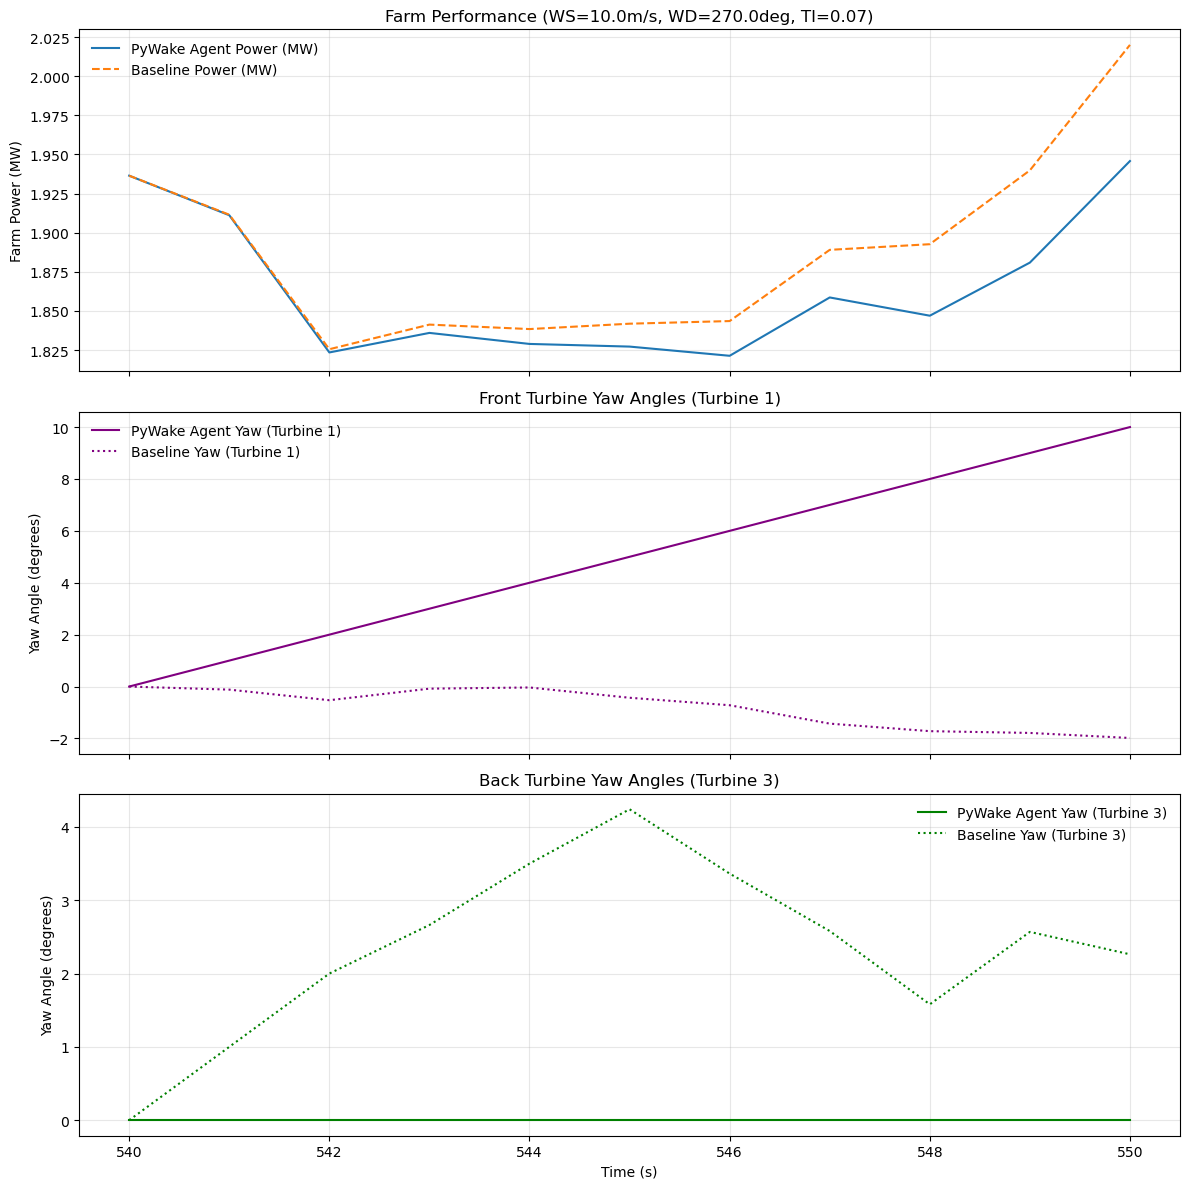


Closing FarmEval environment...
FarmEval environment closed.


In [7]:
# Select a single wind speed, direction, and TI for plotting, assuming eval_results has these dimensions
selected_data = eval_results.sel(ws=10.0, wd=270.0, TI=0.07, method='nearest')
#print(selected_data['powerF_a'].head())

# Access the underlying data for plotting, and use .squeeze() to remove singleton dimensions
agent_power = selected_data['powerF_a'].squeeze().values 
baseline_power = selected_data['powerF_b'].squeeze().values 
time_steps = selected_data['time'].values

agent_yaw_all_turbines = selected_data['yaw_a'].squeeze().values
baseline_yaw_all_turbines = selected_data['yaw_b'].squeeze().values

front_turbine_idx = np.argmin(x_pos_eval)
back_turbine_idx = np.argmax(x_pos_eval)

# One for power, one for front turbine yaw, one for back turbine yaw
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True) # Increased figsize for 3 plots

# Plot 1: Farm Power Output
ax1.plot(time_steps, agent_power / 1e6, label='PyWake Agent Power (MW)')
ax1.plot(time_steps, baseline_power / 1e6, label='Baseline Power (MW)', linestyle='--')
ax1.set_ylabel('Farm Power (MW)')
ax1.set_title(f'Farm Performance (WS={selected_data.ws.item()}m/s, WD={selected_data.wd.item()}deg, TI={selected_data.TI.item()})')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Front Turbine Yaw Angle
ax2.plot(time_steps, agent_yaw_all_turbines[:, front_turbine_idx], label=f'PyWake Agent Yaw (Turbine {front_turbine_idx+1})', color='purple')
ax2.plot(time_steps, baseline_yaw_all_turbines[:, front_turbine_idx], label=f'Baseline Yaw (Turbine {front_turbine_idx+1})', color='purple', linestyle=':')
ax2.set_ylabel('Yaw Angle (degrees)')
ax2.set_title(f'Front Turbine Yaw Angles (Turbine {front_turbine_idx+1})') # Specific title
ax2.grid(True, alpha=0.3)
ax2.legend() # Local legend for this plot

# Plot 3: Back Turbine Yaw Angle
ax3.plot(time_steps, agent_yaw_all_turbines[:, back_turbine_idx], label=f'PyWake Agent Yaw (Turbine {back_turbine_idx+1})', color='green')
ax3.plot(time_steps, baseline_yaw_all_turbines[:, back_turbine_idx], label=f'Baseline Yaw (Turbine {back_turbine_idx+1})', color='green', linestyle=':')
ax3.set_ylabel('Yaw Angle (degrees)')
ax3.set_xlabel('Time (s)') # Label x-axis only on the bottom-most plot
ax3.set_title(f'Back Turbine Yaw Angles (Turbine {back_turbine_idx+1})') # Specific title
ax3.grid(True, alpha=0.3)
ax3.legend() # Local legend for this plot

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()


print("\nClosing FarmEval environment...")
eval_env.close() # Important: close the evaluation environment to release resources
print("FarmEval environment closed.")

## 4. Multi-Agent Simulations (`WindFarmEnvMulti`)

WindGym also supports multi-agent environments, where each turbine can be controlled by an independent agent. This is achieved using `WindFarmEnvMulti`, which wraps `WindFarmEnv` to conform to the [PettingZoo Parallel API](https://pettingzoo.farama.org/api/parallel/).

In this setup:
* Each turbine is considered a separate 'agent'.
* `reset()` and `step()` methods return dictionaries where keys are agent IDs (e.g., `'turbine_0'`, `'turbine_1'`).
* Actions provided to `step()` must also be a dictionary with agent IDs as keys.

### Multi-Agent Simulations (`WindFarmEnvMulti`)

WindGym extends its capabilities to **multi-agent environments**, allowing each wind turbine within a farm to be controlled by its own independent agent. This is facilitated by the `WindFarmEnvMulti` class, a specialized wrapper around the core `WindFarmEnv`. It adheres to the **[PettingZoo Parallel API](https://pettingzoo.farama.org/api/parallel/)**, a standard for multi-agent reinforcement learning environments, making it compatible with a wide range of multi-agent algorithms and tools.

In this multi-agent paradigm:

* Each individual wind turbine is treated as a distinct **'agent'**.
* The `reset()` and `step()` methods of the environment return **dictionaries**. The keys of these dictionaries are **agent IDs** (e.g., `'turbine_0'`, `'turbine_1'`), and the values correspond to the observations, rewards, terminations, truncations, or information pertinent to that specific agent.
* Similarly, actions provided to the `step()` method must also be a **dictionary**, mapping agent IDs to their respective actions.

To illustrate this, let's set up a simple multi-agent simulation. We'll use a **leader-follower strategy** where one turbine acts randomly, and the others attempt to align their yaw angles with the leader's previous yaw. This demonstrates inter-agent dynamics within the simulation.

Environment created successfully!
Agents: ['turbine_0', 'turbine_1', 'turbine_2']
\n--- Running simulation with random agents ---
\nSimulation finished and environment closed.


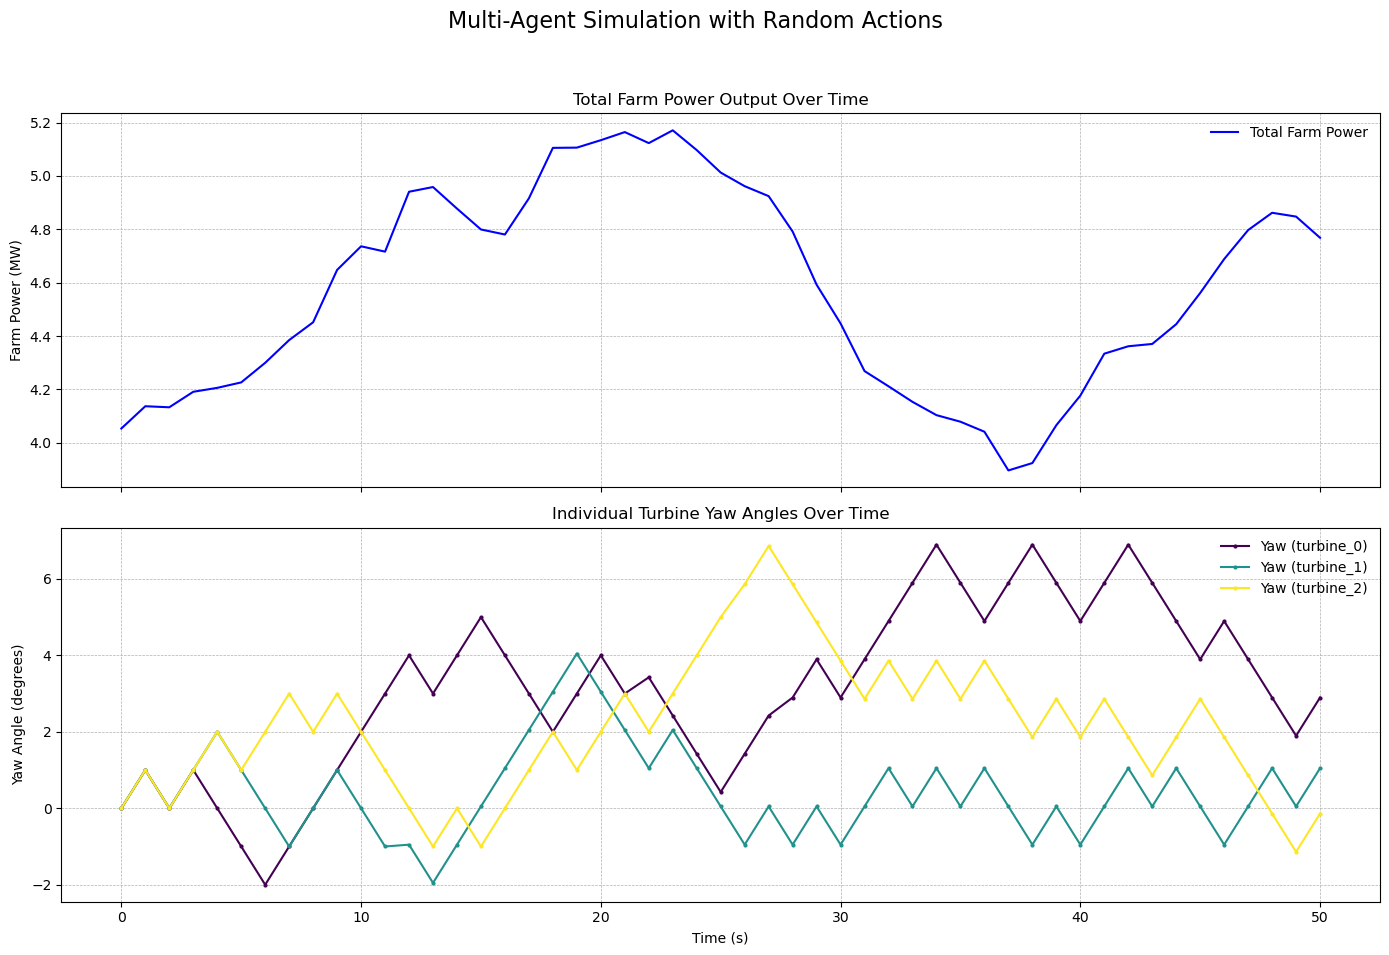

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# Required imports from your environment
from WindGym.utils.generate_layouts import generate_square_grid
from WindGym.WindEnvMulti import WindFarmEnvMulti
from py_wake.examples.data.hornsrev1 import V80

# --- 1. Use the correct, pre-defined YAML configuration ---
config_yaml_content = """
yaw_init: "Zeros"
noise: "None"
BaseController: "Local"
ActionMethod: "wind"
Track_power: False
act_pen:
  action_penalty: 0.0
  action_penalty_type: "Change"
power_def:
  Power_scaling: 1000000000.0
  Power_avg: 50
  Power_reward: "Baseline"
mes_level:
  turb_ws: True
  turb_wd: True
  turb_TI: False
  turb_power: True
  farm_ws: True
  farm_wd: True
  farm_TI: False
  farm_power: True
  ti_sample_count: 30
ws_mes:
  ws_current: False
  ws_rolling_mean: True
  ws_history_N: 1
  ws_history_length: 10
  ws_window_length: 10
wd_mes:
  wd_current: False
  wd_rolling_mean: True
  wd_history_N: 1
  wd_history_length: 10
  wd_window_length: 10
yaw_mes:
  yaw_current: False
  yaw_rolling_mean: True
  yaw_history_N: 2
  yaw_history_length: 30
  yaw_window_length: 1
power_mes:
  power_current: False
  power_rolling_mean: True
  power_history_N: 1
  power_history_length: 10
  power_window_length: 10
farm:
  yaw_min: -45
  yaw_max: 45
wind:
  ws_min: 8.0
  ws_max: 12.0
  TI_min: 0.07
  TI_max: 0.15
  wd_min: 260.0
  wd_max: 280.0
"""

# --- 2. Main Execution Block ---
def main():
    """Initializes the environment, runs a simulation with random agents, and plots the results."""
    
    # --- Setup ---
    yaml_path = 'config.yaml'
    with open(yaml_path, 'w') as f:
        f.write(config_yaml_content)
        
    n_turbines = 3
    x_pos, y_pos = generate_square_grid(turbine=V80(), nx=n_turbines, ny=1, xDist=7, yDist=7)
    
    env = WindFarmEnvMulti(
        turbine=V80(),
        x_pos=x_pos,
        y_pos=y_pos,
        yaml_path=yaml_path,
        render_mode=None
    )
    os.remove(yaml_path)

    print("Environment created successfully!")
    print(f"Agents: {env.possible_agents}")

    # --- Simulation with Random Actions ---
    print("\\n--- Running simulation with random agents ---")
    observations, info = env.reset(seed=42)
    
    # Data logging
    history = {
        'time': [0],
        'power': [env.fs.windTurbines.power().sum()],
        'yaws': {agent: [env.current_yaw[i]] for i, agent in enumerate(env.possible_agents)}
    }
    
    terminated = truncated = False
    max_steps = 50
    step = 0
    while not (terminated or truncated) and step < max_steps:
        actions = {agent: env.action_space(agent).sample() for agent in env.possible_agents}
        observations, rewards, terminations, truncations, infos = env.step(actions)
        
        terminated = any(terminations.values())
        truncated = any(truncations.values())
        
        # Log data for plotting
        info = next(iter(infos.values()))
        # Calculate time manually from the step count and env's time delta (dt_env)
        history['time'].append((step + 1) * env.dt_env)
        history['power'].append(info['Power agent'])
        for i, agent_id in enumerate(env.possible_agents):
            history['yaws'][agent_id].append(env.current_yaw[i])
        
        step += 1

    env.close()
    print("\\nSimulation finished and environment closed.")

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle('Multi-Agent Simulation with Random Actions', fontsize=16)

    # Plot 1: Total Farm Power
    ax1.plot(history['time'], np.array(history['power']) / 1e6, label='Total Farm Power', color='blue')
    ax1.set_title('Total Farm Power Output Over Time')
    ax1.set_ylabel('Farm Power (MW)')
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.legend()

    # Plot 2: Yaw Angles
    colors = plt.cm.viridis(np.linspace(0, 1, n_turbines))
    for i, agent_id in enumerate(history['yaws'].keys()):
        ax2.plot(history['time'], history['yaws'][agent_id], label=f'Yaw ({agent_id})', color=colors[i], marker='.', markersize=4, linestyle='-')

    ax2.set_title('Individual Turbine Yaw Angles Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Yaw Angle (degrees)')
    ax2.grid(True, linestyle='--', linewidth=0.5)
    ax2.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    main()